## 예측에 도움이 되기 위해 최대한 데이터를 늘리자!

### 분기 데이터는 오히려 모델링에 도움이 되지 않았다....

## Hugging Face - FinBert

https://huggingface.co/snunlp/KR-FinBert-SC

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train, Test 데이터 시각화

In [4]:
# 한글 폰트 설정
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 123645 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...



=== TRAIN 데이터 신용등급 개수 ===
credit_rating
AAA     5
AA+     5
AA      1
AA-     2
A+      5
A       2
A-      1
BBB+    2
BBB     2
BBB-    1
BB+     0
BB      0
BB-     0
B+      0
B       0
B-      0
CCC+    0
CCC     0
CCC-    0
CC      0
C       0
Name: count, dtype: int64

총 데이터 수: 26개
총 기업 수: 26개

=== TEST 데이터 신용등급 개수 ===
credit_rating
AAA     3
AA+     0
AA      0
AA-     0
A+      2
A       0
A-      1
BBB+    0
BBB     1
BBB-    0
BB+     1
BB      0
BB-     0
B+      0
B       0
B-      0
CCC+    0
CCC     0
CCC-    0
CC      0
C       0
Name: count, dtype: int64

총 데이터 수: 8개
총 기업 수: 8개


<ipython-input-6-d99ec03f7250>:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_company_dist = train_df.groupby(['company', 'credit_rating']).size().unstack(fill_value=0)


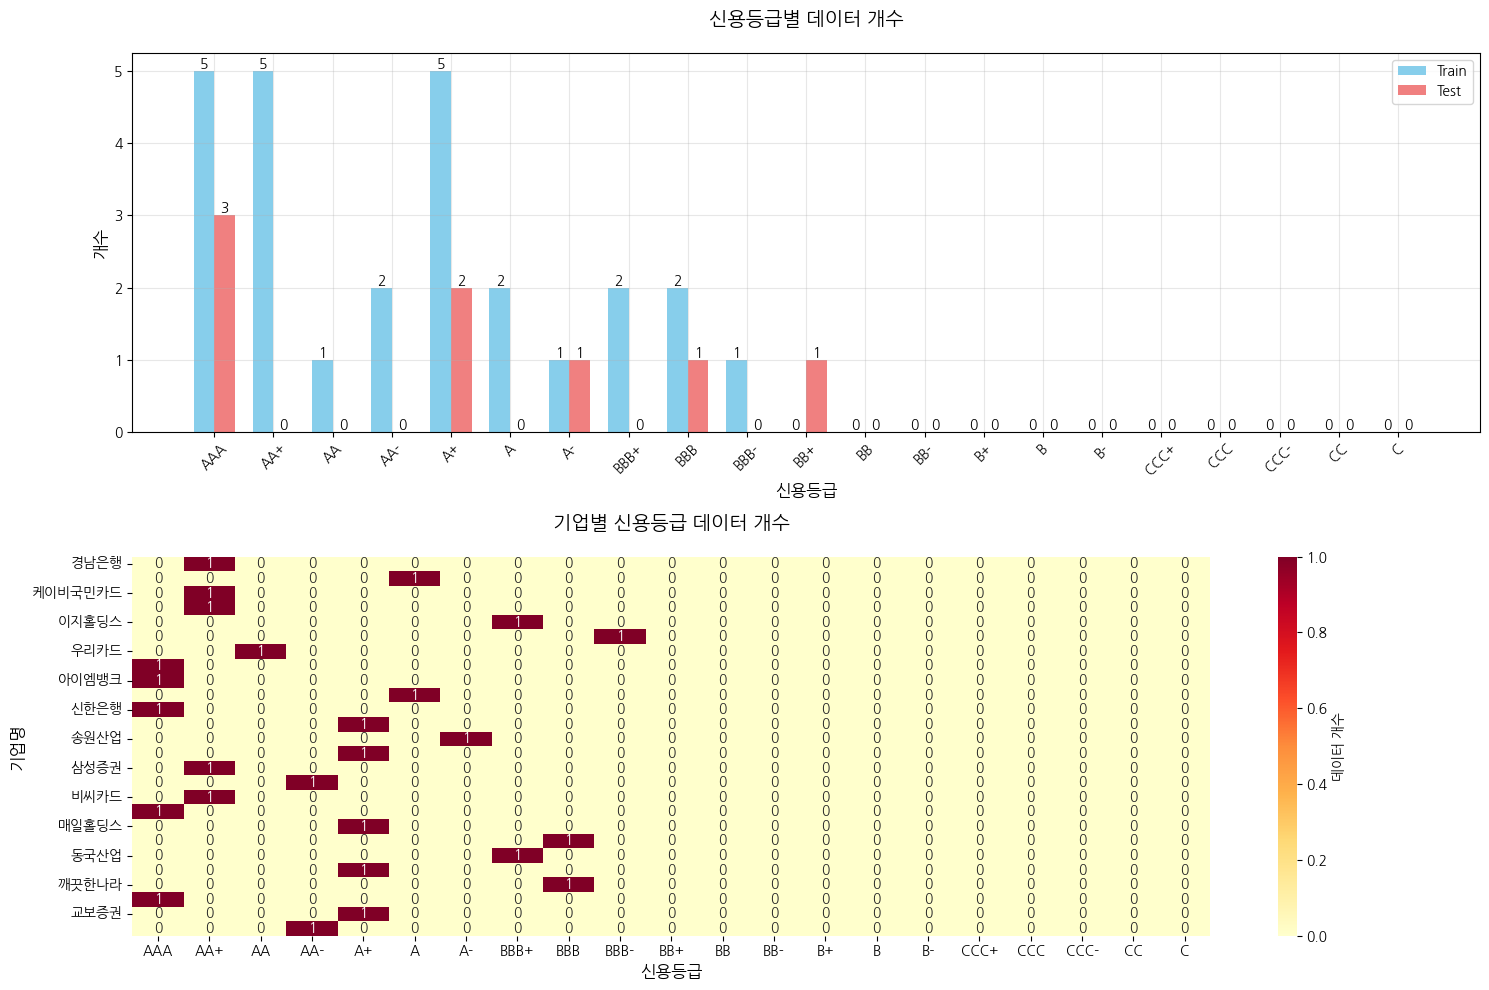

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib import font_manager, rc

# 폰트 경로 직접 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_manager.fontManager.addfont(font_path)

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False


def get_rating_order():
    """신용등급 순서 정의"""
    return ['AAA', 'AA+', 'AA', 'AA-',
            'A+', 'A', 'A-',
            'BBB+', 'BBB', 'BBB-',
            'BB+', 'BB', 'BB-',
            'B+', 'B', 'B-',
            'CCC+', 'CCC', 'CCC-',
            'CC', 'C']

def load_and_analyze_credit_ratings(base_directory):
    """
    TRAIN과 TEST 디렉토리의 신용등급 데이터 분석
    """
    try:
        # 데이터 로드
        train_path = Path(base_directory) / 'TRAIN'
        test_path = Path(base_directory) / 'TEST'

        train_data = []
        test_data = []

        # 데이터 로드
        for file_path in train_path.glob('*.json'):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    train_data.append(json.load(f))
            except Exception as e:
                print(f"파일 로드 중 오류 발생 (TRAIN/{file_path.name}): {e}")
                continue

        for file_path in test_path.glob('*.json'):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    test_data.append(json.load(f))
            except Exception as e:
                print(f"파일 로드 중 오류 발생 (TEST/{file_path.name}): {e}")
                continue

        # DataFrame 변환
        train_df = pd.DataFrame(train_data)
        test_df = pd.DataFrame(test_data)

        # 신용등급 순서 설정
        rating_order = pd.CategoricalDtype(categories=get_rating_order(), ordered=True)
        train_df['credit_rating'] = train_df['credit_rating'].astype(rating_order)
        test_df['credit_rating'] = test_df['credit_rating'].astype(rating_order)

        # 분석 결과 출력
        print("\n=== TRAIN 데이터 신용등급 개수 ===")
        train_dist = train_df['credit_rating'].value_counts().sort_index()
        print(train_dist)
        print(f"\n총 데이터 수: {len(train_df):,}개")
        print(f"총 기업 수: {train_df['company'].nunique():,}개")

        print("\n=== TEST 데이터 신용등급 개수 ===")
        test_dist = test_df['credit_rating'].value_counts().sort_index()
        print(test_dist)
        print(f"\n총 데이터 수: {len(test_df):,}개")
        print(f"총 기업 수: {test_df['company'].nunique():,}개")

        # 시각화
        plt.figure(figsize=(15, 10))

        # 1. 전체 개수 비교 그래프
        plt.subplot(2, 1, 1)

        # 실제 존재하는 신용등급을 순서대로 정렬
        all_ratings = get_rating_order()
        existing_ratings = [r for r in all_ratings if r in train_dist.index or r in test_dist.index]
        x = range(len(existing_ratings))
        width = 0.35

        plt.bar([i - width/2 for i in x],
                [train_dist.get(rating, 0) for rating in existing_ratings],
                width, label='Train', color='skyblue')
        plt.bar([i + width/2 for i in x],
                [test_dist.get(rating, 0) for rating in existing_ratings],
                width, label='Test', color='lightcoral')

        plt.title('신용등급별 데이터 개수', pad=20, size=14)
        plt.xlabel('신용등급', size=12)
        plt.ylabel('개수', size=12)
        plt.xticks(x, existing_ratings, rotation=45)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # 각 막대 위에 숫자 표시
        for i in x:
            train_val = train_dist.get(existing_ratings[i], 0)
            test_val = test_dist.get(existing_ratings[i], 0)

            plt.text(i - width/2, train_val, str(train_val),
                    ha='center', va='bottom')
            plt.text(i + width/2, test_val, str(test_val),
                    ha='center', va='bottom')

        # 2. 기업별 분포
        plt.subplot(2, 1, 2)
        train_company_dist = train_df.groupby(['company', 'credit_rating']).size().unstack(fill_value=0)

        # 데이터가 있는 순서대로 정렬
        companies = train_company_dist.sum(axis=1).sort_values(ascending=False).index
        train_company_dist = train_company_dist.loc[companies]

        # 열(신용등급) 순서 정렬
        existing_columns = [col for col in all_ratings if col in train_company_dist.columns]
        train_company_dist = train_company_dist[existing_columns]

        sns.heatmap(train_company_dist,
                    cmap='YlOrRd',
                    annot=True,
                    fmt='g',  # 정수로 표시
                    cbar_kws={'label': '데이터 개수'})

        plt.title('기업별 신용등급 데이터 개수', pad=20, size=14)
        plt.xlabel('신용등급', size=12)
        plt.ylabel('기업명', size=12)

        plt.tight_layout()
        plt.show()

        return {
            'train_data': train_df,
            'test_data': test_df,
            'train_distribution': train_dist,
            'test_distribution': test_dist,
            'company_distribution': train_company_dist
        }

    except Exception as e:
        print(f"분석 중 오류 발생: {e}")
        return None

# 실행
base_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/JSON"
results = load_and_analyze_credit_ratings(base_dir)

## 모델링

In [2]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import os
import json
import pandas as pd
from datetime import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import numpy as np

class CreditRatingClassifier(nn.Module):
    def __init__(self, num_labels, dropout_rate=0.3):
        super(CreditRatingClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("snunlp/KR-FinBert-SC")
        self.config = AutoConfig.from_pretrained("snunlp/KR-FinBert-SC")
        self.dropout = nn.Dropout(dropout_rate)
        self.num_labels = num_labels

        self.classifier = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        )

        # Freeze BERT layers except last 2
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-2:].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token output
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return F.log_softmax(logits, dim=1)

class CreditRatingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs, save_path):
    best_val_loss = float('inf')
    training_stats = []
    patience = 5
    no_improve = 0

    criterion = nn.NLLLoss()

    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')

        # Training
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_true_labels = []

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            predictions = torch.argmax(logits, dim=1)
            train_predictions.extend(predictions.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')

        # Validation
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

                predictions = torch.argmax(logits, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = np.mean(np.array(val_predictions) == np.array(val_true_labels))
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')

        print(f'Average training loss: {avg_train_loss:.4f}')
        print(f'Training F1 Score: {train_f1:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}')
        print(f'Validation F1 Score: {val_f1:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve = 0
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pt'))
            print("Saved new best model!")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered!")
                break

        training_stats.append({
            'epoch': epoch + 1,
            'training_loss': avg_train_loss,
            'training_f1': train_f1,
            'validation_loss': avg_val_loss,
            'validation_f1': val_f1,
            'validation_accuracy': val_accuracy
        })

    return training_stats

def evaluate_model(model, test_loader, device, label_dict, save_path):
    model.eval()
    predictions = []
    actual_labels = []
    prediction_probs = []
    texts = []  # 원본 텍스트 저장용

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label']

            logits = model(input_ids, attention_mask)
            probs = torch.exp(logits)  # Convert log_softmax to probabilities
            prediction_probs.extend(probs.cpu().numpy())
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    test_f1 = f1_score(actual_labels, predictions, average='weighted', zero_division=0)

    inv_label_dict = {v: k for k, v in label_dict.items()}
    pred_ratings = [inv_label_dict[p] for p in predictions]
    true_ratings = [inv_label_dict[t] for t in actual_labels]

    report = classification_report(true_ratings, pred_ratings, zero_division=0)
    conf_matrix = confusion_matrix(true_ratings, pred_ratings)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    report_path = os.path.join(save_path, f'evaluation_report_{timestamp}.txt')

    # Save detailed predictions with probabilities
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(f"Test F1 Score: {test_f1:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(conf_matrix))
        f.write("\n\nDetailed Predictions:\n")
        f.write("Actual Rating\tPredicted Rating\tConfidence\n")
        f.write("-" * 50 + "\n")
        for true, pred, prob in zip(true_ratings, pred_ratings, prediction_probs):
            confidence = prob[np.argmax(prob)]
            f.write(f"{true}\t\t{pred}\t\t{confidence:.4f}\n")

    print(f"\nTest F1 Score: {test_f1:.4f}")
    print(f"\nDetailed Predictions:")
    print("Actual Rating\tPredicted Rating\tConfidence")
    print("-" * 50)
    for true, pred, prob in zip(true_ratings, pred_ratings, prediction_probs):
        confidence = prob[np.argmax(prob)]
        print(f"{true}\t\t{pred}\t\t{confidence:.4f}")

    print(f"\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    print(f"\nEvaluation report saved to: {report_path}")

    return pred_ratings, true_ratings, report, conf_matrix, test_f1

def prepare_dataset(texts, labels, tokenizer, max_length=512):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

    dataset = torch.utils.data.TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

    return dataset

def load_data(base_folder, mode='TRAIN'):
    json_path = os.path.join(base_folder, 'JSON', mode)

    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Path not found: {json_path}")

    texts = []
    ratings = []
    companies = []

    print(f"Loading {mode} data... Path: {json_path}")

    json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]
    print(f"Found {len(json_files)} JSON files")

    for json_file in tqdm(json_files, desc=f"Loading {mode} data"):
        try:
            with open(os.path.join(json_path, json_file), 'r', encoding='utf-8') as f:
                data = json.load(f)
                texts.append(data['financial_text'])
                ratings.append(data['credit_rating'])
                companies.append(data['company'])
        except Exception as e:
            print(f"Error loading {json_file}: {str(e)}")

    return pd.DataFrame({
        'company': companies,
        'financial_text': texts,
        'credit_rating': ratings
    })

def prepare_data(train_df, test_df):
    all_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-',
                   'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-']

    label_dict = {rating: idx for idx, rating in enumerate(all_ratings)}

    train_texts = train_df['financial_text'].values
    train_labels = [label_dict[rating] for rating in train_df['credit_rating']]

    test_texts = test_df['financial_text'].values
    test_labels = [label_dict[rating] for rating in test_df['credit_rating']]

    return train_texts, train_labels, (test_texts, test_labels), label_dict

In [3]:
def main():
    # 기본 설정
    base_dir = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results"
    model_save_path = "/content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/Fin_BERT/Model"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 데이터 로드
    print("Loading data...")
    train_df = load_data(base_dir, 'TRAIN')
    test_df = load_data(base_dir, 'TEST')

    print(f"Training data size: {len(train_df)}")
    print(f"Test data size: {len(test_df)}")

    # 데이터 준비
    train_texts, train_labels, (test_texts, test_labels), label_dict = prepare_data(train_df, test_df)


     # 데이터 타입 확인 및 출력
    print("\nData types:")
    print(f"train_texts type: {type(train_texts)}")
    print(f"train_labels type: {type(train_labels)}")
    print(f"Sample text: {train_texts[0][:100]}")

    # 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")

    print("\nClass distribution:")
    print("Train:", Counter(train_labels))
    print("Test:", Counter(test_labels))

    # 데이터셋 분할
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.1, random_state=42, #stratify=train_labels
    )

    # 데이터셋 생성
    print("\nPreparing datasets...")
    train_dataset = CreditRatingDataset(train_texts, train_labels, tokenizer)
    val_dataset = CreditRatingDataset(val_texts, val_labels, tokenizer)
    test_dataset = CreditRatingDataset(test_texts, test_labels, tokenizer)

    # 데이터로더 생성
    batch_size = 4  # Increased from 4 for better stability
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

    # 모델 초기화
    num_labels = len(label_dict)
    print(f"\nInitializing model with {num_labels} labels...")
    model = CreditRatingClassifier(num_labels=num_labels)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = AdamW(
        [
            {"params": model.bert.encoder.layer[-2:].parameters(), "lr": 1e-5},
            {"params": model.classifier.parameters(), "lr": 2e-5}
        ],
        weight_decay=0.01
    )

    num_epochs = 5
    num_training_steps = len(train_loader) * num_epochs
    warmup_steps = num_training_steps // 10  # 10% of total steps

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )

    # 모델 학습
    print("\nStarting training...")
    training_stats = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=num_epochs,
        save_path=model_save_path
    )

    # 최적 모델 로드
    print("\nLoading best model...")
    model.load_state_dict(torch.load(os.path.join(model_save_path, 'best_model.pt'),weights_only=True))

    # 테스트 세트에서 평가
    print("\nEvaluating on test set...")
    pred_ratings, true_ratings, report, conf_matrix, f1 = evaluate_model(
        model,
        test_loader,
        device,
        label_dict,
        model_save_path
    )

    print("\nFinal Results:")
    print("-" * 50)
    print(f"Best F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

if __name__ == "__main__":
    main()

Using device: cpu
Loading data...
Loading TRAIN data... Path: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/JSON/TRAIN
Found 26 JSON files


Loading TRAIN data: 100%|██████████| 26/26 [00:10<00:00,  2.59it/s]


Loading TEST data... Path: /content/drive/MyDrive/Colab Notebooks/딥러닝_프로젝트/OCR_results/JSON/TEST
Found 8 JSON files


Loading TEST data: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


Training data size: 26
Test data size: 8

Data types:
train_texts type: <class 'numpy.ndarray'>
train_labels type: <class 'list'>
Sample text: 신용등급 구성체계 한국기업평가 등 급 등 급 정 의 서44 원리금 지급확실성이 최고 수준이다. 44 원리금 지급확실성이 매우 높지만  시등굽에 비하여 다소 낮은 요소가 있다 4 원


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/143k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/294k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Class distribution:
Train: Counter({1: 5, 4: 5, 0: 5, 5: 2, 8: 2, 7: 2, 3: 2, 6: 1, 2: 1, 9: 1})
Test: Counter({0: 3, 4: 2, 8: 1, 6: 1, 10: 1})

Preparing datasets...

Number of batches - Train: 6, Val: 1, Test: 2

Initializing model with 19 labels...


config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/406M [00:00<?, ?B/s]


Starting training...

Epoch 1/5


Validation: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


Average training loss: 2.9865
Training F1 Score: 0.1256
Average validation loss: 3.1316
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 2/5


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


Average training loss: 2.8221
Training F1 Score: 0.2252
Average validation loss: 3.0879
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 3/5


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


Average training loss: 2.9743
Training F1 Score: 0.0710
Average validation loss: 3.0584
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 4/5


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


Average training loss: 2.8170
Training F1 Score: 0.1179
Average validation loss: 3.0417
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Epoch 5/5


Validation: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


Average training loss: 2.9621
Training F1 Score: 0.0316
Average validation loss: 3.0348
Validation F1 Score: 0.0000
Validation Accuracy: 0.0000
Saved new best model!

Loading best model...

Evaluating on test set...


Testing: 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]



Test F1 Score: 0.0714

Detailed Predictions:
Actual Rating	Predicted Rating	Confidence
--------------------------------------------------
A+		A+		0.1276
AAA		A+		0.0834
BBB		A+		0.1012
AAA		A+		0.0970
A-		AAA		0.1213
AAA		CCC+		0.0788
BB+		A+		0.1143
A+		AAA		0.1247

Classification Report:
              precision    recall  f1-score   support

          A+       0.20      0.50      0.29         2
          A-       0.00      0.00      0.00         1
         AAA       0.00      0.00      0.00         3
         BB+       0.00      0.00      0.00         1
         BBB       0.00      0.00      0.00         1
        CCC+       0.00      0.00      0.00         0

    accuracy                           0.12         8
   macro avg       0.03      0.08      0.05         8
weighted avg       0.05      0.12      0.07         8


Confusion Matrix:
[[1 0 1 0 0 0]
 [0 0 1 0 0 0]
 [2 0 0 0 0 1]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]]

Evaluation report saved to: /content/drive/MyDrive/Col